In [156]:
from lake import FrozenLakeEnvStop
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from copy import copy

%matplotlib inline

In [157]:
game = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=0)

In [158]:
print(game.reset())
print(game.render())
print(game.step(0))
print(game.step(1))
print(game.step(1))
print(game.step(1))

{'state': 0, 'gave_feedback': False}

SFFF
FHFH
FFFH
HFFG
None
({'state': 0, 'gave_feedback': False}, 0.0, False, {'prob': 1.0})
({'state': 4, 'gave_feedback': False}, 0.0, False, {'prob': 1.0})
({'state': 8, 'gave_feedback': False}, 0.0, False, {'prob': 1.0})
({'state': 8, 'gave_feedback': True}, 0, False, {'prob': 1.0})


In [159]:
print(game.observation_space)
print(game.action_space)
# action are : 0 Left     1 Down      2  RIGHT     3 UP    

Discrete(16)
Discrete(4)


In [166]:
def test_algo(algo, game, repeat=1):
    
    count_optimal_policy = 0
    count_goal_reach = 0
    
    feedback_list = np.zeros(repeat)
    num_steps_list = np.zeros(repeat)
    
    for test in range(repeat):
        
        num_steps_this_ep = 0
        num_feedback_this_ep = 0

        state = game.reset()
        done = False
        
        while not done:
            action = algo.choose_action_greedy(state)
            state, reward, done, info = game.step(action)
            
            num_steps_this_ep += 1
            num_feedback_this_ep += state['gave_feedback']

        feedback_list[test] = num_feedback_this_ep
        num_steps_list[test] = num_steps_this_ep

        if reward == 1:
            count_goal_reach += 1
        
        #if last reward is 1, we consider that the environment is "solved"
        # if the algo solve the algo N times in a row, '''with the best policy''' => it's okay ! (N = success_to_win)
        if reward == 1 and num_steps_this_ep <= game.shortest_path_length :
            count_optimal_policy += 1
    
    return count_optimal_policy, count_goal_reach, feedback_list.mean(), num_steps_list.mean()

In [175]:
def run_expe(create_algo, game, max_ep, n_tests=5, percentage_to_success=0.9, verbose=True):
    
    first_ep_where_goal_is_reached = max_ep
    
    algo = create_algo()
    
    total_training_steps = 0
    total_feedback_list_train = []
    total_feedback_list_test = []
    percentage_goal_reach_list = []
    num_steps_list = []
    
    
    
    for ep in range(max_ep):
        
        assert algo.current_eps >= algo.minimum_epsilon, "Failed to change epsilon"
        state = game.reset()
        done = False
        
        # Init information to save per episode
        cumul_reward = 0
        num_steps_this_ep = 0
        feedback_train_this_ep = 0
        
        while not done:
            
            action = algo.choose_action_eps_greedy(state)
            next_state, reward, done, info = game.step(action)
            algo.optimize(state, action, next_state, reward)
            
            cumul_reward += reward
            state = next_state
            num_steps_this_ep += 1
            feedback_train_this_ep += next_state['gave_feedback']
            
            # if next_state['gave_feedback']:
            #     print("fais pas ça petit con")
        
        total_training_steps += num_steps_this_ep
        if reward == 1:
            first_ep_where_goal_is_reached = min(first_ep_where_goal_is_reached, ep)
               
        if verbose:
            print("End of ep #{:05d} in {:03d} steps, cumul_reward = {}, current_eps = {}".format(
                    ep,  num_steps_this_ep, cumul_reward, algo.current_eps))
            
        
        total_feedback_list_train.append(feedback_train_this_ep)
        
        count_optimal_policy, count_goal_reach, n_feedback, num_steps = test_algo(algo, game, repeat=n_tests)
        
        total_feedback_list_test.append(n_feedback)
        percentage_goal_reach_list.append(count_goal_reach / n_tests)
        num_steps_list.append(num_steps)

        if count_optimal_policy / n_tests >= percentage_to_success:
            break

    run_info = dict()
    run_info['episode_first_success'] = first_ep_where_goal_is_reached
    run_info['last_ep_number'] = ep
    run_info['final_epsilon'] = algo.current_eps
    run_info['total_training_steps'] = total_training_steps
    run_info['feedback_number_test_list'] = total_feedback_list_test
    run_info['feedback_number_train_list'] = total_feedback_list_train
    run_info['num_steps_list'] = num_steps_list
    run_info['percentage_goal_reach_list'] = percentage_goal_reach_list

    return run_info

In [192]:
def run_multiple_expe(create_algo, game, n_expe, max_ep):
    
    mean_num_ep = np.zeros(n_expe)
    
    num_feedback_per_test_ep = np.zeros((n_expe, max_ep))
    num_feedback_per_train_ep = np.zeros((n_expe, max_ep))

    num_steps_array = np.zeros((n_expe, max_ep))
    percentage_goal_reach_array = np.zeros((n_expe, max_ep))
    
    total_steps_array = np.zeros(n_expe)
    
    for i in range(n_expe):
        run_info = run_expe(create_algo, game, max_ep=max_ep, verbose=False)
        mean_num_ep[i] = run_info['last_ep_number']
        
        # assert run_info['last_ep_timestep'] == game.shortest_path_length or mean_num_ep[i] == max_ep-1, \
        #     "Problem, expes terminated prematurely, {} {} {} {}".format(
        #         run_info['last_ep_timestep'], game.shortest_path_length, mean_num_ep[i], max_ep-1)
        
        num_feedback_test_list = run_info['feedback_number_test_list']
        num_feedback_per_test_ep[i, :len(num_feedback_test_list)] = num_feedback_test_list
        
        num_feedback_train_list = run_info['feedback_number_train_list']
        num_feedback_per_train_ep[i, :len(num_feedback_train_list)] = num_feedback_train_list
        
        
        num_steps_list = run_info['num_steps_list']
        num_steps_array[i, :len(num_steps_list)] = num_steps_list
        num_steps_array[i, len(num_steps_list):] = num_steps_list[-1]

        
        percentage_goal_reach_list  = run_info['percentage_goal_reach_list'] 
        percentage_goal_reach_array[i, :len(percentage_goal_reach_list)] = percentage_goal_reach_list
        percentage_goal_reach_array[i, len(percentage_goal_reach_list):] = percentage_goal_reach_list[-1]
        
        
        total_steps_array[i] = run_info["total_training_steps"]

    print("Total steps to solve environment, mean {}, std {}".format(total_steps_array.mean(), total_steps_array.std()))
    print("Number of episodes mean {}, std {}".format(np.mean(mean_num_ep), np.std(mean_num_ep)))
    
    print("Number of failure to solve env", np.count_nonzero(mean_num_ep==max_ep - 1))
    
    episodes_of_non_failure = mean_num_ep[np.where(mean_num_ep<max_ep-1)]
    print("Number of episodes when not failing", episodes_of_non_failure.mean())
    
    
    sns.tsplot(data=num_feedback_per_test_ep)
    sns.tsplot(data=np.zeros(n_expe))
    plt.title("Number of time feedback is being used during TEST")
    plt.show()
    
    sns.tsplot(data=num_feedback_per_train_ep)
    sns.tsplot(data=np.zeros(n_expe))
    plt.title("Number of time feedback is being used during TRAIN")
    plt.show()
    
    sns.tsplot(data=num_steps_array)
    sns.tsplot(data=np.zeros(n_expe))
    plt.title("Number of steps to reach goal")
    plt.show()
    
    sns.tsplot(data=percentage_goal_reach_array)
    sns.tsplot(data=np.zeros(n_expe))
    plt.title("Percentage of goal reach when testing")
    plt.show()

    return total_steps_array, num_feedback_per_train_ep, num_feedback_per_test_ep, num_steps_array, percentage_goal_reach_array

In [193]:
class TabQLearning(object):
    def __init__(self, env_size, n_action, gamma, lr, expected_exploration_steps):
        
        self.n_action = n_action
        self.env_size = env_size
        self.q_tab = np.zeros((env_size, n_action))
        
        self.lr = lr
        self.gamma = gamma
        
        # Exploration parameters
        self.expected_exploration_steps = expected_exploration_steps
        self.n_step_eps = 0
        self.minimum_epsilon = 0.05
        self.epsilon_init = 1   
        self.current_eps = self.epsilon_init
        
    def choose_action_eps_greedy(self, s):
        
        if np.random.random() < self.current_eps:
            a = np.random.randint(self.n_action)
        else:
            s = s['state']
            a = np.argmax(self.q_tab[s])
        
        self.current_eps = max(self.minimum_epsilon, self.epsilon_init * np.exp(- 2.5 * self.n_step_eps / self.expected_exploration_steps))
        self.n_step_eps += 1
        
        return a
    
    def choose_action_greedy(self, s):
        s = s['state']
        a = np.argmax(self.q_tab[s])
        return a
    
    def optimize(self, state, a, next_state, r):
        state, next_state = state['state'], next_state['state']
        self.q_tab[state, a] = (1-self.lr)*self.q_tab[state, a] + self.lr*(r + self.gamma*np.max(self.q_tab[next_state]))
        
    def test(self):
        self.saved_eps = copy(self.current_eps)
        self.current_eps = 0
    
    def train(self):
        self.current_eps = copy(self.saved_eps)
        assert self.current_eps != 0, "Failed to save eps"
        
gamma = 0.99
expected_exploration_steps = 2000

create_algo = lambda : TabQLearning(16, 4, gamma=gamma,
                                    lr=0.1, expected_exploration_steps=expected_exploration_steps)

game = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=0)
run_res = run_expe(create_algo, game, verbose=True, max_ep=200)

End of ep #00000 in 014 steps, cumul_reward = 1.0, current_eps = 0.9838813189766874
End of ep #00001 in 100 steps, cumul_reward = 0.0, current_eps = 0.868272216507773
End of ep #00002 in 100 steps, cumul_reward = 0.0, current_eps = 0.7662475416683708
End of ep #00003 in 100 steps, cumul_reward = 0.0, current_eps = 0.6762110821353979
End of ep #00004 in 100 steps, cumul_reward = 0.0, current_eps = 0.5967541854778661
End of ep #00005 in 073 steps, cumul_reward = 1.0, current_eps = 0.5447109456345129
End of ep #00006 in 100 steps, cumul_reward = 0.0, current_eps = 0.4807057223263836
End of ep #00007 in 019 steps, cumul_reward = 1.0, current_eps = 0.46942346850496713
End of ep #00008 in 033 steps, cumul_reward = 1.0, current_eps = 0.45045369185138673
End of ep #00009 in 018 steps, cumul_reward = 1.0, current_eps = 0.4404316545059993


In [186]:
class TabQLearningControlerFeedback(object):
    def __init__(self, env_size, n_action, gamma, lr, expected_exploration_steps, margin):
        
        self.n_action = n_action
        self.env_size = env_size
        self.q_tab = np.zeros((env_size, n_action))
        
        self.lr = lr
        self.gamma = gamma
        self.margin = margin
        
        # Exploration parameters
        self.expected_exploration_steps = expected_exploration_steps
        self.n_step_eps = 0
        self.minimum_epsilon = 0.05
        self.epsilon_init = 1   
        self.current_eps = self.epsilon_init
        
    def choose_action_greedy(self, s):
        s = s['state']
        a = np.argmax(self.q_tab[s])
        return a      

    def choose_action_eps_greedy(self, s):
        
        s = s['state']
        
        if np.random.random() < self.current_eps:
            a = np.random.randint(self.n_action)
        else:
            a = np.argmax(self.q_tab[s])
            
        self.current_eps = max(self.minimum_epsilon, self.epsilon_init * np.exp(- 2.5 * self.n_step_eps / self.expected_exploration_steps))
        self.n_step_eps += 1
        
        return a
    
    def optimize(self, state, action, next_state, r):
        
        state = state['state']

        gave_feedback = next_state['gave_feedback']        
        next_state = next_state['state']

        if gave_feedback:
            bad_action = action
            q_with_margin = [self.q_tab[state, a] - self.margin_loss(bad_action, a) for a in range(self.n_action)]
            self.q_tab[state, action] = (1 - self.lr) * self.q_tab[state, action] + self.lr * min(q_with_margin)
        else:
            self.q_tab[state, action] = (1 - self.lr) * self.q_tab[state, action] + self.lr * (r + self.gamma * np.max(self.q_tab[next_state]))
            
    def test(self):
        self.saved_eps = self.current_eps
        self.current_eps = 0
    
    def train(self):
        self.current_eps = self.saved_eps
        assert self.current_eps != 0, "Failed to save eps"
        
    def margin_loss(self, bad_action, a):
        if bad_action == a:
            return 0
        else:
            return self.margin
        
        
gamma = 0.99
expected_exploration_steps = 2000
margin=0.2
lr = 0.7

create_algo = lambda : TabQLearningControlerFeedback(16, 4, gamma=gamma,
                                    lr=lr, expected_exploration_steps=expected_exploration_steps, margin=margin)

game = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=0)
run_res = run_expe(create_algo, game, verbose=True, max_ep=200)

End of ep #00000 in 100 steps, cumul_reward = 0.0, current_eps = 0.8836007134508922
End of ep #00001 in 030 steps, cumul_reward = 1.0, current_eps = 0.8510792746900349
End of ep #00002 in 076 steps, cumul_reward = 1.0, current_eps = 0.773948457489971
End of ep #00003 in 100 steps, cumul_reward = 0.0, current_eps = 0.6830071164950248
End of ep #00004 in 064 steps, cumul_reward = 1.0, current_eps = 0.6304950339349585
End of ep #00005 in 059 steps, cumul_reward = 1.0, current_eps = 0.5856692901447937
End of ep #00006 in 026 steps, cumul_reward = 1.0, current_eps = 0.5669410210369252
End of ep #00007 in 012 steps, cumul_reward = 1.0, current_eps = 0.5585003688742262


Frozen-Lake Deterministe avec Feedback
-------------------

Q-Learning Tabulaire, pas de récompenses négatives

Total steps to solve environment, mean 4070.2, std 7595.651519915853
Number of episodes mean 42.28, std 74.88822070259114
Number of failure to solve env 90
Number of episodes when not failing 7.878048780487805


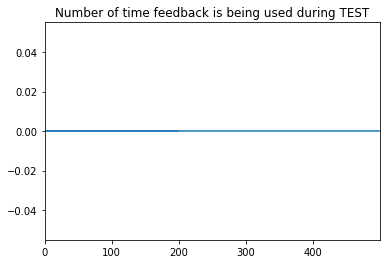

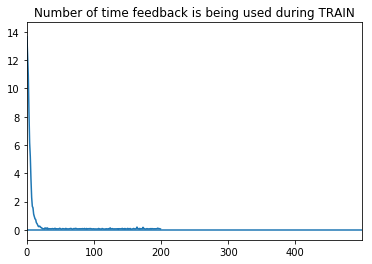

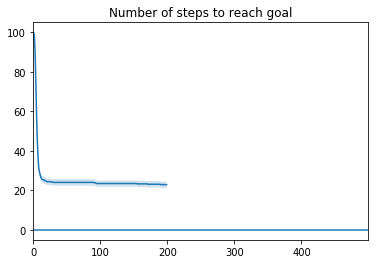

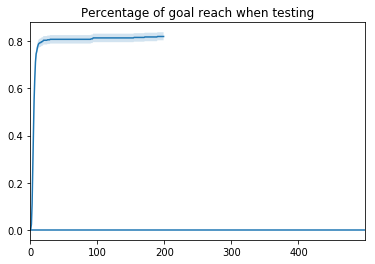

In [200]:
gamma = 0.99
expected_exploration_steps = 2000
lr=0.7

algo = lambda : TabQLearning(16, 4, gamma=gamma, lr=lr, expected_exploration_steps=expected_exploration_steps)
game = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=0)

res_det_no_feedback = run_multiple_expe(algo, game, n_expe=500, max_ep=200)

Q-Learning Tabulaire, récompenses négatives de l'environement

Total steps to solve environment, mean 1108.798, std 3756.3223601277887
Number of episodes mean 12.848, std 37.07971003122867
Number of failure to solve env 19
Number of episodes when not failing 5.494802494802495


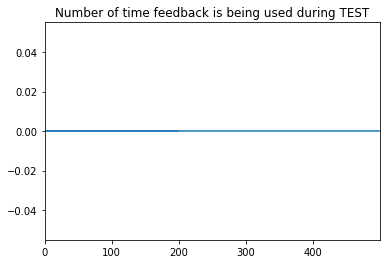

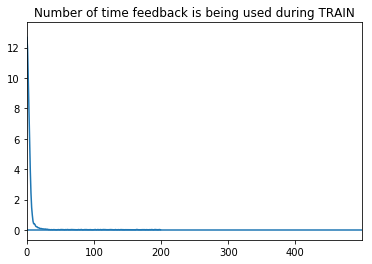

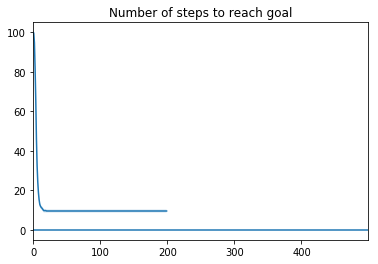

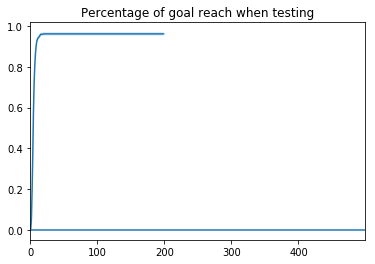

In [201]:
gamma = 0.99
expected_exploration_steps = 3000
reward_when_falling = -0.1
lr = 0.7

algo = lambda : TabQLearning(16, 4, gamma=gamma, lr=lr, expected_exploration_steps=expected_exploration_steps)
game = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=reward_when_falling)

res_det_neg_rew = run_multiple_expe(algo, game, n_expe=500, max_ep=200)

Q-Learning Tabulaire inclusion du Feedback, pas de récompenses négatives de l'environnement

Total steps to solve environment, mean 1173.276, std 3847.0913266809766
Number of episodes mean 13.646, std 37.92688603088843
Number of failure to solve env 20
Number of episodes when not failing 5.922916666666667


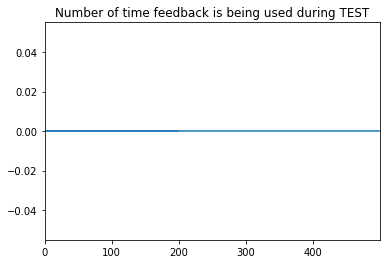

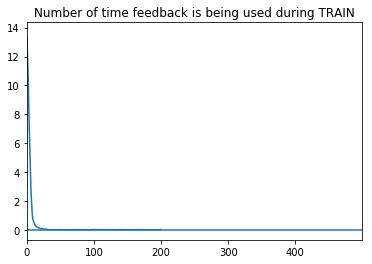

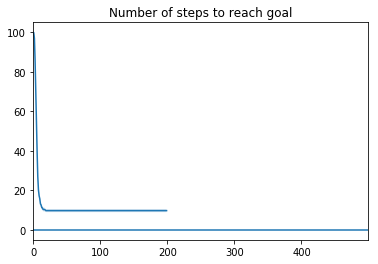

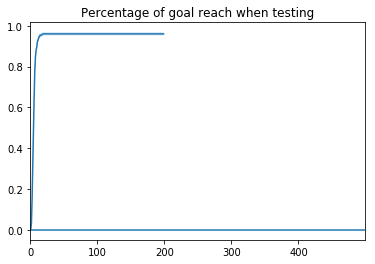

In [203]:
gamma = 0.99
expected_exploration_steps = 3000
margin= 0.2
lr = 0.7

algo = lambda : TabQLearningControlerFeedback(16, 4, gamma=gamma, lr=lr, expected_exploration_steps=expected_exploration_steps, margin=margin)
game = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=0)

res_det_neg_feedback = run_multiple_expe(algo, game, n_expe=500, max_ep=200)

Frozen-Lake Non-Deterministe avec Feedback
-------------------

In [66]:
game = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=0)
print("deterministe", game.P)


game = FrozenLakeEnvStop(is_slippery=True, reward_when_falling=0)
print("non deterministic", game.P)

deterministe {0: {0: [(1.0, 0, 0.0, False)], 1: [(1.0, 4, 0.0, False)], 2: [(1.0, 1, 0.0, False)], 3: [(1.0, 0, 0.0, False)]}, 1: {0: [(1.0, 0, 0.0, False)], 1: [(1.0, 5, 0.0, True)], 2: [(1.0, 2, 0.0, False)], 3: [(1.0, 1, 0.0, False)]}, 2: {0: [(1.0, 1, 0.0, False)], 1: [(1.0, 6, 0.0, False)], 2: [(1.0, 3, 0.0, False)], 3: [(1.0, 2, 0.0, False)]}, 3: {0: [(1.0, 2, 0.0, False)], 1: [(1.0, 7, 0.0, True)], 2: [(1.0, 3, 0.0, False)], 3: [(1.0, 3, 0.0, False)]}, 4: {0: [(1.0, 4, 0.0, False)], 1: [(1.0, 8, 0.0, False)], 2: [(1.0, 5, 0.0, True)], 3: [(1.0, 0, 0.0, False)]}, 5: {0: [(1.0, 5, 0, True)], 1: [(1.0, 5, 0, True)], 2: [(1.0, 5, 0, True)], 3: [(1.0, 5, 0, True)]}, 6: {0: [(1.0, 5, 0.0, True)], 1: [(1.0, 10, 0.0, False)], 2: [(1.0, 7, 0.0, True)], 3: [(1.0, 2, 0.0, False)]}, 7: {0: [(1.0, 7, 0, True)], 1: [(1.0, 7, 0, True)], 2: [(1.0, 7, 0, True)], 3: [(1.0, 7, 0, True)]}, 8: {0: [(1.0, 8, 0.0, False)], 1: [(1.0, 12, 0.0, True)], 2: [(1.0, 9, 0.0, False)], 3: [(1.0, 4, 0.0, False)]

In [74]:
gamma = 0.99
expected_exploration_steps = 3000
margin=0.2

create_algo = lambda : TabQLearningControlerFeedback(16, 4, gamma=gamma,
                                                     lr=0.1, expected_exploration_steps=expected_exploration_steps, margin=margin)

game = FrozenLakeEnvStop(is_slippery=True, reward_when_falling=-0.1)

run_expe(create_algo, game, verbose=True)




SFFF
FHFH
FFFH
HFFG
None
End of ep #00000 in 069 steps, cumul_reward = 1.1102230246251565e-16
End of ep #00001 in 100 steps, cumul_reward = -1.4000000000000001
End of ep #00002 in 022 steps, cumul_reward = 0.8
End of ep #00003 in 100 steps, cumul_reward = -1.7000000000000004
End of ep #00004 in 049 steps, cumul_reward = -0.19999999999999996
End of ep #00005 in 088 steps, cumul_reward = -0.8000000000000005
End of ep #00006 in 044 steps, cumul_reward = 0.6
End of ep #00007 in 090 steps, cumul_reward = 0.20000000000000007
End of ep #00008 in 030 steps, cumul_reward = 0.7


9

This seems very easy to solve because of the controller stopping from doing stupid stuff, the explo is easy.

Q-Learning Tabulaire, pas de récompenses négatives

In [84]:
gamma = 0.99
expected_exploration_steps = 3000
lr = 0.7

algo = lambda : TabQLearning(16, 4, gamma=gamma, lr=lr, expected_exploration_steps=expected_exploration_steps)
game = FrozenLakeEnvStop(is_slippery=True, reward_when_falling=0)

run_multiple_expe(algo, game, n_expe=1000)

Number of episodes mean 15.509
Number of failure to solve env 4
Number of episodes when not failing 13.53807615230461


Q-Learning Tabulaire, récompenses négatives de l'environnement

In [86]:
gamma = 0.99
expected_exploration_steps = 3000
lr = 0.7

algo = lambda : TabQLearning(16, 4, gamma=gamma, lr=lr, expected_exploration_steps=expected_exploration_steps)
game = FrozenLakeEnvStop(is_slippery=True, reward_when_falling=-0.1)

run_multiple_expe(algo, game, n_expe=1000)

Number of episodes mean 15.721
Number of failure to solve env 0
Number of episodes when not failing 15.721


Q-Learning Tabulaire inclusion du Feedback, pas de récompenses négatives de l'environnement

In [88]:
gamma = 0.99
expected_exploration_steps = 3000
margin= 0.2
lr = 0.7


algo = lambda : TabQLearningControlerFeedback(16, 4, gamma=gamma, lr=lr, expected_exploration_steps=expected_exploration_steps, margin=margin)
game = FrozenLakeEnvStop(is_slippery=True, reward_when_falling=0)

run_multiple_expe(algo, game, n_expe=1000)

Number of episodes mean 20.311
Number of failure to solve env 1
Number of episodes when not failing 20.311


In [7]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
class QModel(nn.Module):
    def __init__(self, size_in, n_action):
        super().__init__()
        
        self.n_hidden = 10
        self.n_action = n_action
        self.input_size = size_in
        
        self.fc1 = nn.Linear(self.input_size, self.n_hidden)
        self.fc2 = nn.Linear(self.n_hidden, self.n_action)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            qs = policy_net(state)
            return qs.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [11]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [12]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 40
LR = 6e-3

env = gym.make('CartPole-v0').unwrapped

env_size = env.observation_space.shape[0]
n_actions = env.action_space.n

policy_net = QModel(size_in=env_size, n_action=n_actions).to(device)
target_net = QModel(size_in=env_size, n_action=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)

num_episodes = 1000
cumul_reward = 0
rew_list = []


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = torch.FloatTensor(env.reset()).unsqueeze(0)
    assert isinstance(state, torch.Tensor)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        
        cumul_reward += reward
        
        reward = torch.tensor([reward], device=device)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        assert isinstance(next_state, torch.Tensor)
        
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            rew_list.append(cumul_reward)
            cumul_reward = 0
            break
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        print("End of ep #{}, cumul_reward : {}".format(i_episode, np.mean(rew_list)))
        rew_list = []

        target_net.load_state_dict(policy_net.state_dict())
    



End of ep #0, cumul_reward : 35.0


End of ep #40, cumul_reward : 42.175


End of ep #80, cumul_reward : 16.525


End of ep #120, cumul_reward : 25.6


End of ep #160, cumul_reward : 139.8


End of ep #200, cumul_reward : 153.75


End of ep #240, cumul_reward : 197.175


End of ep #280, cumul_reward : 148.1


End of ep #320, cumul_reward : 215.3


End of ep #360, cumul_reward : 202.9


End of ep #400, cumul_reward : 186.125


End of ep #440, cumul_reward : 153.325


End of ep #480, cumul_reward : 153.75


End of ep #520, cumul_reward : 153.875


End of ep #560, cumul_reward : 120.075


End of ep #600, cumul_reward : 124.325


End of ep #640, cumul_reward : 154.6


End of ep #680, cumul_reward : 122.325


End of ep #720, cumul_reward : 129.975


End of ep #760, cumul_reward : 54.5


End of ep #800, cumul_reward : 171.325


End of ep #840, cumul_reward : 131.6


End of ep #880, cumul_reward : 253.675


End of ep #920, cumul_reward : 202.175


End of ep #960, cumul_reward : 168.625


In [24]:
num_episodes = 1000
cumul_reward = 0
rew_list = []

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 30
LR = 3e-3

env = FrozenLakeEnvStop(is_slippery=False, reward_when_falling=-0.1)

n_actions = env.action_space.n
state_size = 1


policy_net = QModel(size_in=state_size, n_action=n_actions).to(device)
target_net = QModel(size_in=state_size, n_action=n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)


for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.FloatTensor([state]).unsqueeze(0)
    assert isinstance(state, torch.Tensor)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        
        cumul_reward += reward
        
        reward = torch.tensor([reward], device=device)
        next_state = torch.FloatTensor([next_state]).unsqueeze(0)
        assert isinstance(next_state, torch.Tensor)
        
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            rew_list.append(cumul_reward)
            cumul_reward = 0
            break
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        print("End of ep #{}, cumul_reward : {}".format(i_episode, np.mean(rew_list)))
        rew_list = []

        target_net.load_state_dict(policy_net.state_dict())

End of ep #0, cumul_reward : 0.0


End of ep #30, cumul_reward : -0.1233333333333333


End of ep #60, cumul_reward : 0.043333333333333314


End of ep #90, cumul_reward : 0.019999999999999976


End of ep #120, cumul_reward : 0.13000000000000017


End of ep #150, cumul_reward : -0.08666666666666632


End of ep #180, cumul_reward : -0.1966666666666667


End of ep #210, cumul_reward : 0.006666666666666685


End of ep #240, cumul_reward : -0.4333333333333335


End of ep #270, cumul_reward : -1.3133333333333335


End of ep #300, cumul_reward : -1.516666666666667


End of ep #330, cumul_reward : -0.2033333333333333


End of ep #360, cumul_reward : 0.29000000000000004


End of ep #390, cumul_reward : 0.25333333333333335


End of ep #420, cumul_reward : -0.14666666666666664


End of ep #450, cumul_reward : 0.15


End of ep #480, cumul_reward : -0.020000000000000007


End of ep #510, cumul_reward : -0.26


End of ep #540, cumul_reward : -0.32


End of ep #570, cumul_reward : -0.43333333333333335


End of ep #600, cumul_reward : -0.24333333333333337


End of ep #630, cumul_reward : -0.2966666666666667


End of ep #660, cumul_reward : -0.5033333333333329


End of ep #690, cumul_reward : -0.06666666666666668


End of ep #720, cumul_reward : -0.04666666666666666


End of ep #750, cumul_reward : -0.04000000000000001


End of ep #780, cumul_reward : -0.11333333333333333


End of ep #810, cumul_reward : -0.06333333333333334


End of ep #840, cumul_reward : -0.0033333333333333335


End of ep #870, cumul_reward : -0.0033333333333333335


End of ep #900, cumul_reward : -0.04000000000000001


End of ep #930, cumul_reward : -0.07666666666666667


End of ep #960, cumul_reward : -0.22


End of ep #990, cumul_reward : -0.04000000000000001
